In [1]:
import logging
import os

from matplotlib import pyplot as plt
import numpy as np

from src.hnmf_optimizer import HNMFOptimizer
from src.clusts import result_analysis
from green_model import reconstruct_general, gen_init_params,  gen_bounds, clustering_preprocess


# set true variables

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#       set true variables for generated observations       #
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

### parameters ###

# # 5 sources
As = np.array([0.4, 0.3,0.2,0.5,0.7])
# positions of the source
Xs = np.array([
  [-0.25,0.45],
  [-0.08,0.2],
  [-0.15,0.25],
  [0.1,-0.1],
  [0.3,0.3]
])

# Advection velocity
u_scaler = 0.05
# U = tf_c(np.array([0.05, 0]))
# Dispersivity
D = np.array([0.005, 0.00125])


### fixed known values ###

# the initial time the sources begin the release
Ts = -10.

Xd = np.array([
[ -0.2,0.6],
[0,0.6],
[0.2,0.6],
[0.4,0.6],
[0.6,0.6],
[-0.2,0.4],
[0,0.4],
[0.2,0.4],
[0.4,0.4],
[0.6,0.4],
[-0.2,0.2],
[0,0.2],
[0.2,0.2],
[0.4,0.2],
[0.6,0.2],
[-0.2,0.0],
[0,0.0],
[0.2,0.0],
[0.4,0.0],
[0.6,0.0],
[-0.2,-0.2],
[0,-0.2],
[0.2,-0.2],
[0.4,-0.2],
[0.6,-0.2],
[-0.2,-0.4],
[0,-0.4],
[0.2,-0.4],
[0.4,-0.4],
[0.6,-0.4]
])

# time values of data
t = np.linspace(0, 20, 80)

# noise to add to 
noise_level = 1e-4


# NMF run

In [3]:
# generate observations from target variables with small noise

noise_level = 1e-4
observations = reconstruct_general(As, Xs, Ts, Xd, t, np.array([u_scaler]), D)
noise = noise_level/2 - noise_level*np.random.rand(*observations.shape)
observations += noise

I0000 00:00:1697816960.675262   22561 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [4]:
green_opt = HNMFOptimizer(
    model_fn = reconstruct_general,
    param_generator = gen_init_params,
    bound_generator = gen_bounds,
    input_args = ('t',),
    param_args = ('A_s', 'X_s', 'U', 'D'),
    constants = {'T_s': Ts, 'X_d': Xd},
    min_k = 1,
    max_k = 7,
    nsim = 100
)

res = green_opt(
    t,
    observations,
    opt_options = {
        'maxiter': 1500,
        'xtol': 1e-6,
        'fatol': 1e-10,
    }
)
Forclusts = clustering_preprocess(res)

Forclusts = Forclusts.groupby('num_sources', group_keys=False).apply(lambda group: result_analysis(
    group['points'].sum(),
    group['normF'].mean(),
    observations.size,
    group['num_sources'].iloc[0]
))

SIMULATIONS FOR 1 SOURCES TOOK 16.822446823120117 SECONDS
SIMULATIONS FOR 2 SOURCES TOOK 11.618147373199463 SECONDS
SIMULATIONS FOR 3 SOURCES TOOK 17.31515383720398 SECONDS
SIMULATIONS FOR 4 SOURCES TOOK 21.581907510757446 SECONDS
SIMULATIONS FOR 5 SOURCES TOOK 177.81746292114258 SECONDS
SIMULATIONS FOR 6 SOURCES TOOK 154.56659412384033 SECONDS
SIMULATIONS FOR 7 SOURCES TOOK 97.78693699836731 SECONDS
Clustering  2
Clustering  3
Clustering  4
Clustering  5
Clustering  6
Clustering  7


In [5]:
Forclusts

,num_source,aic_score,avg_sillhouette_score,min_sillhouette_score,reconstruction_loss,centers
0,1,-1.323365e+04,1.000000,1.000000,9.663626,"[1.4999960107177914, 0.01696485920865705, 0.25..."
0,2,-1.573193e+04,1.000000,1.000000,3.409570,"[[0.7656063397091941, 1.253653290696718], [0.1..."
0,3,-1.802936e+04,1.000000,1.000000,1.307991,"[[0.4616800922253318, 0.518488085842864, 0.923..."
0,4,-2.838683e+04,1.000000,1.000000,0.017458,"[[0.7036133051289473, 0.4874446541113035, 0.41..."
0,5,-3.283306e+04,0.996175,0.981370,0.002736,"[[0.5000358524616103, 0.4000185011945063, 0.30..."
0,6,-3.283124e+04,0.760734,-0.263038,0.002735,"[[0.6884845998911153, 0.4000129049750455, 0.38..."
0,7,inf,0.243348,-0.335408,0.002779,"[[0.4221621003527528, 0.2925221000789683, 0.22..."


In [6]:
def plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all, output_dir):
    fig, ax1 = plt.subplots()
    color = 'tab:blue'
    ax1.set_xlabel('Number of Sources')
    ax1.set_ylabel('Reconstruction Error [%]', color=color)  # we already handled the x-label with ax1
    ax1.plot(numsources, recs_all, color=color,marker = 'o')
    ax1.tick_params(axis='y', labelcolor=color)
    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:red'
    ax2.set_ylabel('Silhouette Score', color=color)
    ax2.plot(numsources, avgsilsall, color=color,label='Avg_sil',marker = 'o')
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.plot(numsources, minsillsall, color='pink', label='Min_sill', marker='o')
    ax2.legend(loc='upper right')
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.savefig(output_dir+"Selection_plot.png")
    plt.show()

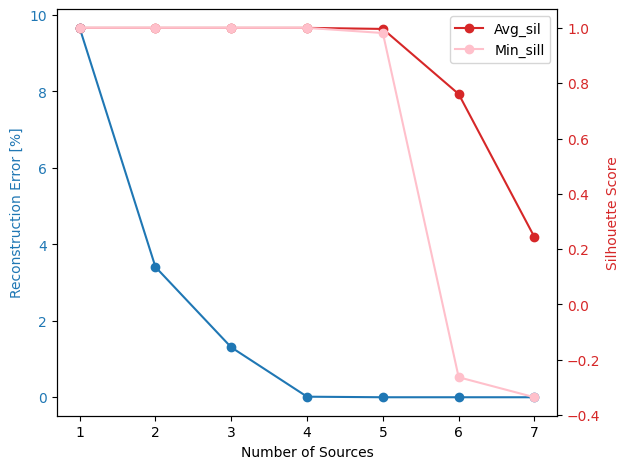

In [7]:
OUTPUTDIR = "Results/"
os.makedirs(OUTPUTDIR,exist_ok=True)

numsources = Forclusts['num_source'].values
avgsilsall    = Forclusts['avg_sillhouette_score'].values
minsillsall   = Forclusts['min_sillhouette_score'].values
recs_all   = Forclusts['reconstruction_loss'].values
plot_results_stability_plot(numsources,avgsilsall,minsillsall,recs_all,OUTPUTDIR)

In [8]:
Forclusts['centers'].iloc[4]

array([[ 0.50003585,  0.4000185 ,  0.30193502,  0.70000457,  0.19800061],
       [ 0.09999472, -0.24999307, -0.08025534,  0.30000473, -0.15034171],
       [-0.09998844,  0.44999285,  0.2002308 ,  0.29999509,  0.2501894 ],
       [ 0.04999982,  0.04999982,  0.04999982,  0.04999982,  0.04999982],
       [ 0.00499995,  0.00499995,  0.00499995,  0.00499995,  0.00499995],
       [ 0.00125002,  0.00125002,  0.00125002,  0.00125002,  0.00125002]])

In [9]:
ground_truth=np.vstack([As,Xs.T])
ground_truth

array([[ 0.4 ,  0.3 ,  0.2 ,  0.5 ,  0.7 ],
       [-0.25, -0.08, -0.15,  0.1 ,  0.3 ],
       [ 0.45,  0.2 ,  0.25, -0.1 ,  0.3 ]])